In [33]:
import cv2
import os
import random
import stat
import uuid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.metrics import Precision, Recall
import app_data
from app_data import verify_image
import utils

In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#SSTEP 1
POS_PATH = os.path.join('Image', 'positive')
NEG_PATH = os.path.join('Image', 'negative')
ANC_PATH = os.path.join('Image', 'anchor')

#STEP 2 then deactivate
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

#Step 3.1
#To get around the win 5 error i used jupyter-lab and replaced the last string line for os.replace(Ex...) and replaced with NEW_PATH
pathways = 'C:/Users/lyork/source/repos/RealProject/lfw'

#Step 3.2 then deactivate
#for directory in os.listdir(pathways):
    #for file in os.listdir(os.path.join('C:/Users/lyork/source/repos/RealProject/lfw', directory)):
        #EX_PATH = os.path.join('C:/Users/lyork/source/repos/RealProject/lfw', directory, file)
        #NEW_PATH = os.path.join('C:/Users/lyork/source/repos/RealProject/RealProject/Image', file)
        #os.replace(EX_PATH, 'C:/Users/lyork/source/repos/RealProject/RealProject/Image')


anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(45)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(20)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(45)


b'Image\\anchor\\d215eb0c-d841-11ed-8f0d-18c04d230772.jpg'
0.0


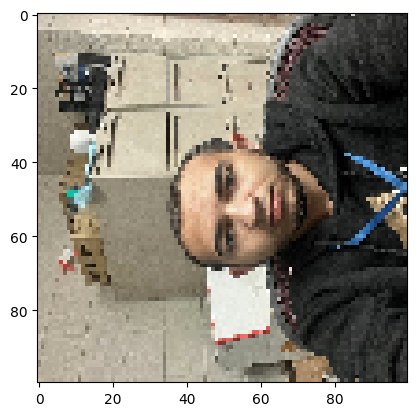

In [35]:
ANC_PATH+'\*.jpg'

dir_test = anchor.as_numpy_iterator()

print(dir_test.next())


#Data Preprocessor is essential, will make this a seperate file later - Scaling and Resizing
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

img = preprocess('Image\\anchor\\Austin3.jpg')
print(img.numpy().min())
plt.imshow(img)

(b'Image\\anchor\\d2eb7ee6-d841-11ed-bb9d-18c04d230772.jpg', b'Image\\positive\\Lamar14.jpg', 1.0)


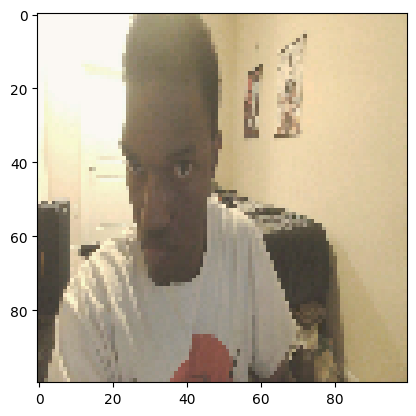

In [36]:
#Creation of the labelled dataset
#(anchor, postitive) => 1,1,1,1,1

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

samples = data.as_numpy_iterator()

examp = samples.next()
print(examp)

#Gonna preprocess the stew out of these images

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*examp)

plt.imshow(res[0])

#print(res[2])

#Build the pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

3
65
46
3
[[[[0.98039216 0.9764706  0.9607843 ]
   [0.98039216 0.9764706  0.9607843 ]
   [0.98039216 0.9764706  0.9607843 ]
   ...
   [0.855098   0.7707838  0.60607886]
   [0.84313726 0.7607843  0.5921569 ]
   [0.8235294  0.7490196  0.58431375]]

  [[0.98039216 0.9764706  0.9607843 ]
   [0.98039216 0.9764706  0.9607843 ]
   [0.98039216 0.9764706  0.9607843 ]
   ...
   [0.85372615 0.765883   0.6013729 ]
   [0.8509798  0.7655295  0.605568  ]
   [0.8316473  0.7504705  0.57831395]]

  [[0.98039216 0.9764706  0.9607843 ]
   [0.98039216 0.9764706  0.9607843 ]
   [0.98039216 0.9764706  0.9607843 ]
   ...
   [0.85000074 0.7666657  0.5980397 ]
   [0.85607815 0.76980364 0.6168625 ]
   [0.84078443 0.76627463 0.60941184]]

  ...

  [[0.31960785 0.2882353  0.2509804 ]
   [0.3384314  0.29137257 0.22862746]
   [0.39117646 0.33431372 0.2735294 ]
   ...
   [0.6882348  0.62352943 0.43725348]
   [0.6888234  0.62215674 0.4496077 ]
   [0.71352947 0.62725496 0.47431377]]

  [[0.32160836 0.30666664 0.2434123

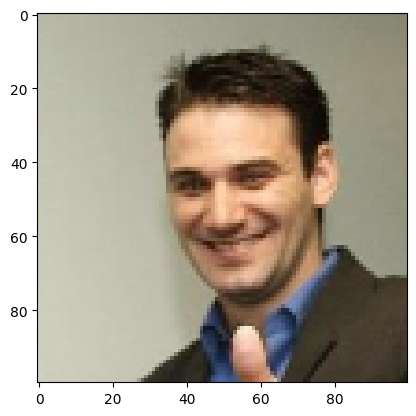

In [37]:
sampss = data.as_numpy_iterator()

yooo = sampss.next()
plt.imshow(yooo[1])
print(len(yooo))
print(len(data))
#We finally getting to the big Leagues!!
#Training partition!

print(round(len(data)*.7))

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
print(len(train_samples.next()))
print(train_sample[0])
print(train_data)

#this prints out 16 images because of the batch size. Gonna lower it though because i dont have a bunch on had


print(len(train_sample[0]))

# Gonna do the testing partition now
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [38]:
round(len(data)*.3)


20

In [39]:
inp = Input(shape=(100,100,3), name='input_image')

In [40]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [41]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [42]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [43]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [44]:
#Building the embedding layer
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    #First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #Final FORM!
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

In [45]:
embedding = make_embedding()

embedding.summary()

#Building the Distance Layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


l1 = L1Dist()
siamese_layer = L1Dist()



Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

In [46]:
input_image = Input(name='input_img', shape=(100,100,3))

In [47]:
validation_image = Input(name='validation_img', shape=(100,100,3))

In [48]:
siamese_layer = L1Dist()
siamese_layer._name = 'distance'
distances = siamese_layer(embedding(input_image), embedding(validation_image))

In [49]:
classifier = Dense(1, activation='sigmoid')(distances)

In [65]:

def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()

siamese_model.summary()



Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [66]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

#I will now lay waste to the land of checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

#Train Step Function
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
print(batch_1[2])

[1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


In [67]:
X = batch_1[:2]

In [68]:
y = batch_1[2]

In [69]:
y

array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [70]:
X

(array([[[[0.7921961 , 0.68196076, 0.48396078],
          [0.78392154, 0.6820785 , 0.48666662],
          [0.78764707, 0.69      , 0.49411765],
          ...,
          [0.9550976 , 0.8256849 , 0.63588136],
          [0.9529412 , 0.81960785, 0.6392157 ],
          [0.9372549 , 0.8160785 , 0.63058823]],
 
         [[0.8109804 , 0.6890196 , 0.5330589 ],
          [0.80282354, 0.6921961 , 0.5095295 ],
          [0.7860784 , 0.69196075, 0.5154902 ],
          ...,
          [0.953922  , 0.8301957 , 0.6196072 ],
          [0.95607847, 0.82509804, 0.63803923],
          [0.9500784 , 0.8167451 , 0.6308628 ]],
 
         [[0.8       , 0.7019608 , 0.48313725],
          [0.79490197, 0.69803923, 0.53254896],
          [0.7980392 , 0.69215685, 0.50784314],
          ...,
          [0.9607843 , 0.83137256, 0.62156814],
          [0.9607843 , 0.827451  , 0.6509804 ],
          [0.95647067, 0.8270589 , 0.6270589 ]],
 
         ...,
 
         [[0.18784314, 0.1564706 , 0.14862746],
          [0.16470

In [57]:
@tf.function
def train_step(batch):

    #automatic recording of the inside of the neural network
    with tf.GradientTape() as tape:

        X = batch[:2]
        
        y = batch[2]

        yhat = siamese_model(X, training=True)

        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [71]:
def train(data, EPOCHS):

    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):

            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        
        epoch_recall = r.result().numpy()
        epoch_precision = p.result().numpy()
        history_recall.append(epoch_recall)
        history_precision.append(epoch_precision)
        
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [72]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [73]:
y_hat = siamese_network.predict([test_input, test_val])

1/1 [==============================] - 1s 931ms/step


In [74]:
EPOCHS = 10

history_recall, history_precision = train(train_data, EPOCHS)

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

y_hat = siamese_model.predict([test_input, test_val])

[1 if prediction > 0.5 else 0 for prediction in y_hat]

print(y_true)

#Metrics calculation!
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()


#Creation of the metric object
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_network.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)



print(r.result().numpy(), p.result().numpy())

epochs = range(1, EPOCHS + 1)



 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [64]:
#Saving the weights (Update the weights also works)
siamese_model.save('siamesemodelv2.h5')
L1Dist



NameError: name 'siamese_model' is not defined

In [160]:
#Reloading of the siamese model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', custom_objects = {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

siamese_model.predict([test_input, test_val])
#Viewing the model summary
t1 = siamese_model.summary()
print(t1)

1/1 [==============================] - 1s 730ms/step
Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                

IndexError: index 10 is out of bounds for axis 0 with size 10

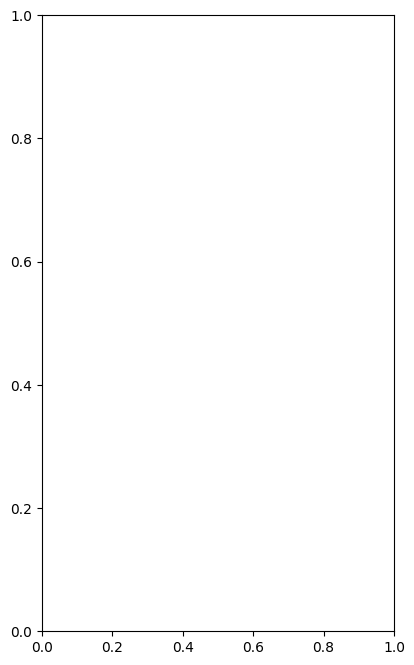

In [166]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[2])

plt.subplot(1,2,2)
plt.imshow(test_val[2])

plt.show()

plt.plot(epochs, history_recall, 'b', label='Recall')
plt.plot(epochs, history_precision, 'r', label='Precision')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Recall and Precision by Epoch')
plt.legend()
plt.show()

3

 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 20s 6s/step
0.06363748 1.0 1.0

 Epoch 2/10
2/2 [==============================] - 19s 5s/step
0.3917608 1.0 1.0

 Epoch 3/10
2/2 [==============================] - 19s 5s/step
0.21315493 1.0 0.9285714

 Epoch 4/10
2/2 [==============================] - 19s 5s/step
0.15254326 1.0 1.0

 Epoch 5/10
2/2 [==============================] - 19s 5s/step
0.005447671 1.0 1.0

 Epoch 6/10
2/2 [==============================] - 19s 5s/step
0.022764431 1.0 1.0

 Epoch 7/10
2/2 [==============================] - 19s 5s/step
0.029004475 1.0 1.0

 Epoch 8/10
2/2 [==============================] - 19s 5s/step
0.012446 1.0 1.0

 Epoch 9/10
2/2 [==============================] - 19s 5s/step
0.00285082 1.0 1.0

 Epoch 10/10
2/2 [==============================] - 19s 5s/step
0.0038312497 1.0 1.0
1/1 [

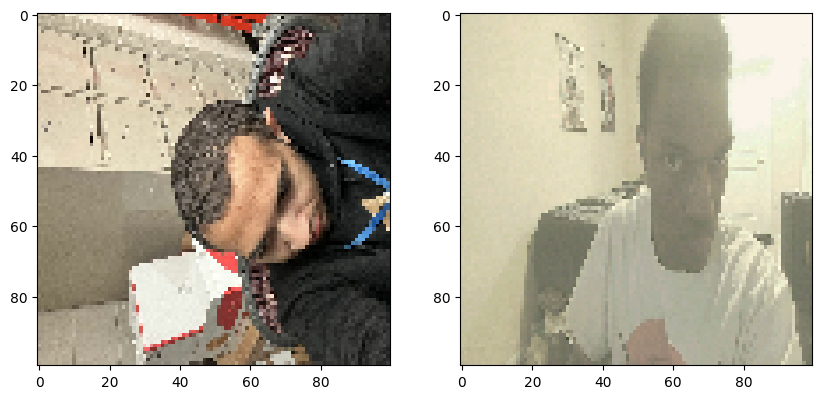

app_data\verify_image\Ausitn22.jpg
app_data\verify_image\Austin1.jpg
app_data\verify_image\Austin2.jpg
app_data\verify_image\Austin3.jpg
app_data\verify_image\Austin4.jpg
app_data\verify_image\Lamar21.jpg
app_data\verify_image\Lamar22.jpg
app_data\verify_image\Lamar3.jpg
app_data\verify_image\Lamar4.jpg
app_data\verify_image\Lamar5.jpg


KeyboardInterrupt: 

In [27]:
from RealProject import *
from RPTraining import *
from keras.metrics import Precision, Recall
import cv2
import app_data
from app_data import verify_image

In [28]:
#app_data\verify_image

In [167]:
os.listdir(os.path.join('app_data', 'verify_image'))

['20230419_034603.jpg',
 '20230419_034611.jpg',
 '20230419_034614.jpg',
 '20230419_034629.jpg',
 '20230419_034631.jpg',
 '20230419_034632.jpg',
 'Ausitn22.jpg',
 'Austin1.jpg',
 'Austin10.jpg',
 'Austin11.jpg',
 'Austin2.jpg',
 'Austin3.jpg',
 'Austin4.jpg',
 'Austin7.jpg',
 'Austin8.jpg',
 'Austin9.jpg',
 'Lamar21.jpg',
 'Lamar22.jpg',
 'Lamar3.jpg',
 'Lamar4.jpg',
 'Lamar5.jpg']

In [168]:
os.path.join('app_data', 'input_image', 'input_image.jpg')

'app_data\\input_image\\input_image.jpg'

In [169]:
for image in os.listdir(os.path.join('app_data', 'verify_image')):
    validation_img = os.path.join('app_data', 'verify_image', image )
    print(validation_img)

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('app_data', 'verify_image')):
        input_img = preprocess(os.path.join('app_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('app_data', 'verify_image', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('app_data', 'verify_image'))) 
    verified = verification > verification_threshold
    
    return results, verified



app_data\verify_image\20230419_034603.jpg
app_data\verify_image\20230419_034611.jpg
app_data\verify_image\20230419_034614.jpg
app_data\verify_image\20230419_034629.jpg
app_data\verify_image\20230419_034631.jpg
app_data\verify_image\20230419_034632.jpg
app_data\verify_image\Ausitn22.jpg
app_data\verify_image\Austin1.jpg
app_data\verify_image\Austin10.jpg
app_data\verify_image\Austin11.jpg
app_data\verify_image\Austin2.jpg
app_data\verify_image\Austin3.jpg
app_data\verify_image\Austin4.jpg
app_data\verify_image\Austin7.jpg
app_data\verify_image\Austin8.jpg
app_data\verify_image\Austin9.jpg
app_data\verify_image\Lamar21.jpg
app_data\verify_image\Lamar22.jpg
app_data\verify_image\Lamar3.jpg
app_data\verify_image\Lamar4.jpg
app_data\verify_image\Lamar5.jpg


In [172]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('w'):
    #This part will be modified with the xml file for the haar cascade to detect then do the siamese model.

        cv2.imwrite(os.path.join('app_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 217ms/step
False
1/1 [==============================] - 0s 225ms/step
False
1/1 [==============================] - 0s 205ms/step
False
1/1 [==============================] - 0s 221ms/step
False
1/1 [==============================] - 0s 202ms/step
False
1/1 [==============================] - 0s 215ms/step
False
1/1 [==============================] - 0s 213ms/step
False
1/1 [==============================] - 0s 214ms/step
False
1/1 [==============================] - 0s 221ms/step
False
